In [159]:
from os import path

# Third-party
from astropy.constants import c
from astropy.table import Table, Column
from astropy.io import fits
import astropy.coordinates as coord
import astropy.units as u
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
plt.style.use('apw-notebook')
%matplotlib inline
from scipy.special import wofz

# Project
from comoving_rv.longslit.fitting import fit_spec_line_GP, gp_to_fit_pars, voigt_polynomial
from comoving_rv.longslit import GlobImageFileCollection

## Find exposures that are long enough, find centroid of O lines at 5577, 6300, 6364 and see how they vary with airmass

In [204]:
def fit_sky_region(x, flux, ivar, center, width, plot=False):
    _idx = np.abs(x - center) < width # x pixels on either side of center
    
    x = x[_idx]
    flux = flux[_idx]
    ivar = ivar[_idx]
    
    sort_ = x.argsort()
    wave_data = x[sort_]
    flux_data = flux[sort_]
    err_data = 1/np.sqrt(ivar[sort_])
    
    gp = fit_spec_line_GP(wave_data, flux_data, ivar, absorp_emiss=1.)

    wave_grid = np.linspace(wave_data.min(), wave_data.max(), 256)
    mu, var = gp.predict(flux_data, wave_grid, return_var=True)
    std = np.sqrt(var)
    
    fit_pars = gp_to_fit_pars(gp, 1.)
    
    if plot:
        # ------------------------------------------------------------------------
        # Plot the maximum likelihood model
        fig,ax = plt.subplots()

        # data
        ax.plot(wave_data, flux_data, drawstyle='steps-mid', marker='')
        ax.errorbar(wave_data, flux_data, err_data,
                    marker='', ls='none', ecolor='#666666', zorder=-10)

        # mean model
        ax.plot(wave_grid, voigt_polynomial(wave_grid, **fit_pars),
                marker='', alpha=0.5)

        # full GP model
        gp_color = "#ff7f0e"
        ax.plot(wave_grid, mu, color=gp_color, marker='')
        ax.fill_between(wave_grid, mu+std, mu-std, color=gp_color,
                        alpha=0.3, edgecolor="none")

        ax.set_xlabel(r'wavelength [$\AA$]')
        ax.set_ylabel('flux')

        fig.tight_layout()
    
    # some validation
    max_ = fit_pars['amp'] * wofz((1j * fit_pars['fwhm_L']/2) / (np.sqrt(2)*fit_pars['std_G'])).real
    max_ /= np.sqrt(2*np.pi*fit_pars['std_G']**2) 
    
    if ((abs(fit_pars['x0']-center) > 4) or (fit_pars['amp'] < 32) or 
            (fit_pars['std_G'] > 4) or (fit_pars['fwhm_L'] > 4.) or 
            (max_ > 2*flux_data.max())):
        # FAILED
        return None
    
    return fit_pars

In [205]:
def sky_line_centroids(tbl, line_waves=[5577., 6300., 6364.], window_width=15, plot=False):    
    with np.errstate(invalid='ignore'):
        clean = np.isfinite(tbl['wavelength']) & (tbl['wavelength'] > 0)
    
    line_idx = [np.argmin(np.abs(tbl['wavelength'][clean] - w)) 
                for w in [5577., 6300., 6364.]]
    line_pixels = tbl['pix'][clean][line_idx]
    
    pixl = tbl['pix']
    flux = tbl['background_flux']
    ivar = tbl['background_ivar']
    
    fit_centroids = []
    for pix_ctr in line_pixels:
        pars = fit_sky_region(pixl, flux, ivar, 
                              pix_ctr, window_width, plot=plot)

        if pars is None:
            fit_centroids.append(np.nan)
            if plot: plt.title('fucked')
            
        else:
            fit_centroids.append(pars['x0'])
    
    return np.array(fit_centroids)

In [236]:
# # testing
# filename = '/Volumes/ProjectData/gaia-comoving-followup/data/processed/mdm-spring-2017/n1/1d_n1.0036.fit'
# tbl = fits.getdata(filename, 1)
# sky_line_centroids(tbl, plot=True)

In [222]:
stat_tbl = Table()
stat_tbl.add_column(Column(name='object', dtype='|U64'))
stat_tbl.add_column(Column(name='filename', dtype='|U128'))
stat_tbl.add_column(Column(name='night', dtype='i4'))
stat_tbl.add_column(Column(name='secz'))
stat_tbl.add_column(Column(name='line_centers', shape=(3,)))

In [223]:
for n in range(1, 5+1):
    base_path = '/Volumes/ProjectData/gaia-comoving-followup/data/processed/mdm-spring-2017/n' + str(n)
    ifc = GlobImageFileCollection(location=base_path, glob_include='1d*')

    print(n)
    for filename in ifc.files_filtered(IMAGETYP='OBJECT'):
        file_path = path.abspath(path.join(ifc.location, filename))
        hdr = fits.getheader(file_path)
        if hdr['EXPTIME'] < 30:
            continue
        
        tbl = fits.getdata(file_path, 1)
        line_centers = sky_line_centroids(tbl)
        stat_tbl.add_row([hdr['OBJECT'], file_path, n, hdr['AIRMASS'], line_centers])

1


/Users/adrian/projects/gaia-comoving-followup/comoving_rv/longslit/fitting.py:185: RuntimeWarning: overflow encountered in exp
  return voigt_polynomial(x, self._absorp_emiss*np.exp(self.ln_amp), self.x0,
/Users/adrian/projects/gaia-comoving-followup/comoving_rv/longslit/models.py:45: RuntimeWarning: divide by zero encountered in true_divide
  z = (_x + 1j*L_fwhm/2.) / (np.sqrt(2.)*G_std)
/Users/adrian/projects/gaia-comoving-followup/comoving_rv/longslit/models.py:45: RuntimeWarning: invalid value encountered in true_divide
  z = (_x + 1j*L_fwhm/2.) / (np.sqrt(2.)*G_std)
/Users/adrian/anaconda/envs/comoving-rv/lib/python3.6/site-packages/celerite/terms.py:448: RuntimeWarning: invalid value encountered in double_scalars
  S0 = np.exp(2.0 * self.log_sigma) / w0
/Users/adrian/projects/gaia-comoving-followup/comoving_rv/longslit/fitting.py:249: RuntimeWarning: invalid value encountered in log
  p0['ln_amp'] = np.log(absorp_emiss * p0.pop('amp'))
/Users/adrian/anaconda/envs/comoving-rv/lib/

2


/Users/adrian/anaconda/envs/comoving-rv/lib/python3.6/site-packages/celerite/terms.py:449: RuntimeWarning: overflow encountered in double_scalars
  return (w0*S0, w0*w0*S0/self.eps, w0, self.eps)
/Users/adrian/anaconda/envs/comoving-rv/lib/python3.6/site-packages/celerite/terms.py:447: RuntimeWarning: overflow encountered in exp
  w0 = np.sqrt(3.0) * np.exp(-self.log_rho)
/Users/adrian/anaconda/envs/comoving-rv/lib/python3.6/site-packages/celerite/terms.py:449: RuntimeWarning: invalid value encountered in double_scalars
  return (w0*S0, w0*w0*S0/self.eps, w0, self.eps)


3


/Users/adrian/anaconda/envs/comoving-rv/lib/python3.6/site-packages/celerite/terms.py:448: RuntimeWarning: overflow encountered in exp
  S0 = np.exp(2.0 * self.log_sigma) / w0
/Users/adrian/projects/gaia-comoving-followup/comoving_rv/longslit/fitting.py:186: RuntimeWarning: overflow encountered in exp
  np.exp(self.ln_std_G), np.exp(self.ln_fwhm_L),


4
5


/Users/adrian/projects/gaia-comoving-followup/comoving_rv/longslit/models.py:47: RuntimeWarning: invalid value encountered in true_divide
  return amp * wofz(z).real / (np.sqrt(2.*np.pi)*G_std)
/Users/adrian/anaconda/envs/comoving-rv/lib/python3.6/site-packages/celerite/terms.py:448: RuntimeWarning: divide by zero encountered in double_scalars
  S0 = np.exp(2.0 * self.log_sigma) / w0


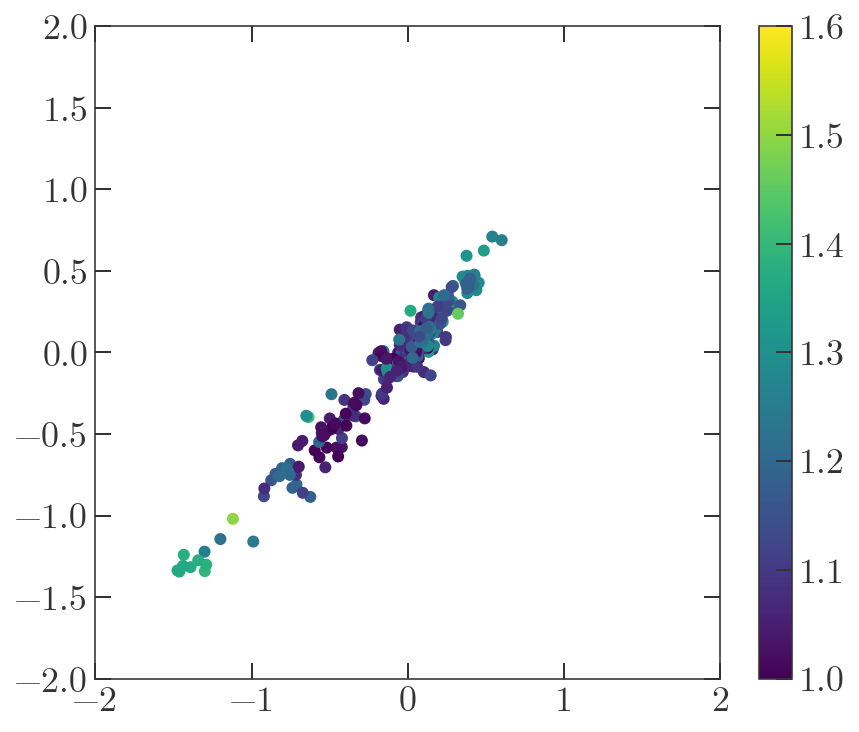

In [234]:
l = 0
r = 1

plt.figure(figsize=(7,6))
for n in range(1, 5+1):
    night_tbl = stat_tbl[stat_tbl['night'] == n]
    
    plt.scatter(night_tbl['line_centers'][:,l]-np.nanmedian(night_tbl['line_centers'][:,l]), 
                night_tbl['line_centers'][:,r]-np.nanmedian(night_tbl['line_centers'][:,r]), 
                c=night_tbl['secz'], vmin=1., vmax=1.6)

plt.xlim(-2, 2)
plt.ylim(-2, 2)
plt.colorbar()